In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from utility import feature_engineering, get_model_scores, plot_cms, plot_feature_importance

import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Data Loading and Preprocessing

In [2]:
df0 = pd.read_csv("../data/HR_capstone_dataset.csv")
df_dummy = feature_engineering(df0)

df_dummy.head()

satisfaction_level  last_evaluation  number_projects  \
0                0.38             0.53                2   
1                0.80             0.86                5   
2                0.11             0.88                7   
3                0.72             0.87                5   
4                0.37             0.52                2   

   average_monthly_hours  time_spent_company  work_accident  left  \
0                    157                   3              0     1   
1                    262                   6              0     1   
2                    272                   4              0     1   
3                    223                   5              0     1   
4                    159                   3              0     1   

   promotion_last_5_years  salary  department_IT  department_RandD  \
0                       0       0          False             False   
1                       0       1          False             False   
2                       0       1          False             False   
3                       0       0          False             False   
4                       0       0          False             False   

   department_accounting  department_hr  department_management  \
0                  False          False                  False   
1                  False          False                  False   
2                  False          False                  False   
3                  False          False                  False   
4                  False          False                  False   

   department_marketing  department_product_mng  department_sales  \
0                 False                   False              True   
1                 False                   False              True   
2                 False                   False              True   
3                 False                   False              True   
4                 False                   False              True   

   department_support  department_technical  time_per_project  
0               False                 False         78.500000  
1               False                 False         52.400000  
2               False                 False         38.857143  
3               False                 False         44.600000  
4               False                 False         79.500000

### Data splitting

In [3]:
X = df_dummy.drop(['left'], axis=1)
X_nosat = df_dummy.drop(['satisfaction_level', 'left'], axis=1)

y = df_dummy['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_nosat, X_test_nosat, y_train_nosat, y_test_nosat = train_test_split(X_nosat, y, test_size=0.2, random_state=42, stratify=y)

# Single Decision Tree Model

We start by performing a grid search for the best hyperparameters for a single decision tree model.

In [4]:
decision_tree = DecisionTreeClassifier(random_state=0)

cv_params_dt = {'max_depth': [5, 7, 9, 11, 13], 'min_samples_split': [10, 15, 20, 30], 'min_samples_leaf': [1, 2, 3, 4, 5], 'max_features': [None, 'sqrt']}

scoring = {'f1': 'f1'}

dt_grid_search = GridSearchCV(estimator=decision_tree, param_grid=cv_params_dt, cv=5, scoring=scoring, refit='f1', return_train_score=True)

dt_grid_search.fit(X_train, y_train)
y_pred_dt = dt_grid_search.predict(X_test)

results = get_model_scores('dec_tree', y_pred_dt, y_test)

print(results.iloc[-1, :])

model        dec_tree
accuracy     0.983326
precision    0.973545
recall       0.924623
f1           0.948454
Name: 0, dtype: object


The decision tree already gives great Performance. We now want to check how well it holds up if we drop the satisfaction level from features.

In [5]:
dt_grid_search_nosat = GridSearchCV(estimator=decision_tree, param_grid=cv_params_dt, cv=5, scoring=scoring, refit='f1', return_train_score=True)

dt_grid_search_nosat.fit(X_train_nosat, y_train_nosat)

y_pred_dt_nosat = dt_grid_search_nosat.predict(X_test_nosat)

results = pd.concat([results, get_model_scores('dec_tree_nosat', y_pred_dt_nosat, y_test)])

print(results.iloc[-1, :])

model        dec_tree_nosat
accuracy           0.974573
precision          0.924433
recall             0.922111
f1                  0.92327
Name: 0, dtype: object


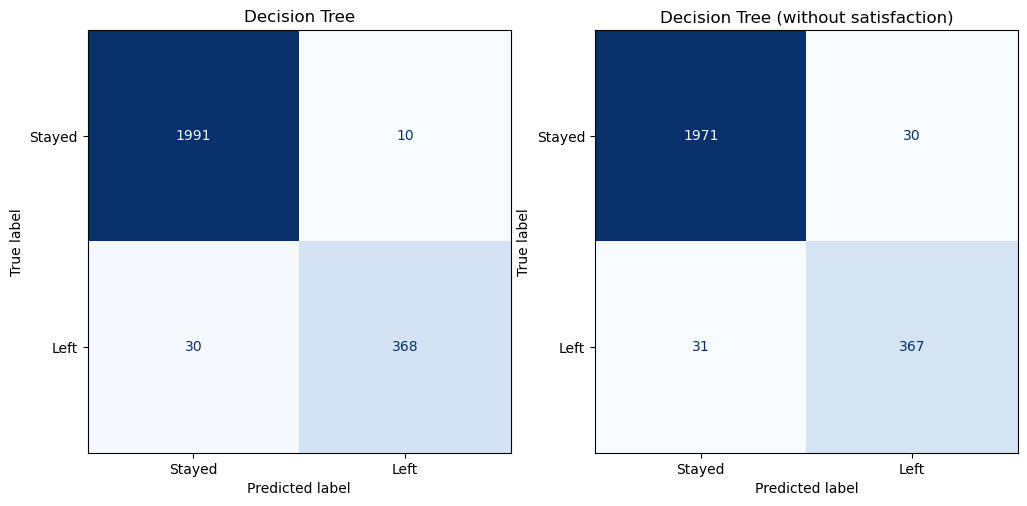

In [6]:
plot_cms(y_pred_dt, y_pred_dt_nosat, y_test, 'Decision Tree')

We can see that the model is still able to predict the classes quite well. The false negative rate is increased by a factor of 3, but the false positive rate is constant.
Looking at the feature importance, we can clearly identify the tenure, working hours, last evaluation, and the number of projects as the most important features.

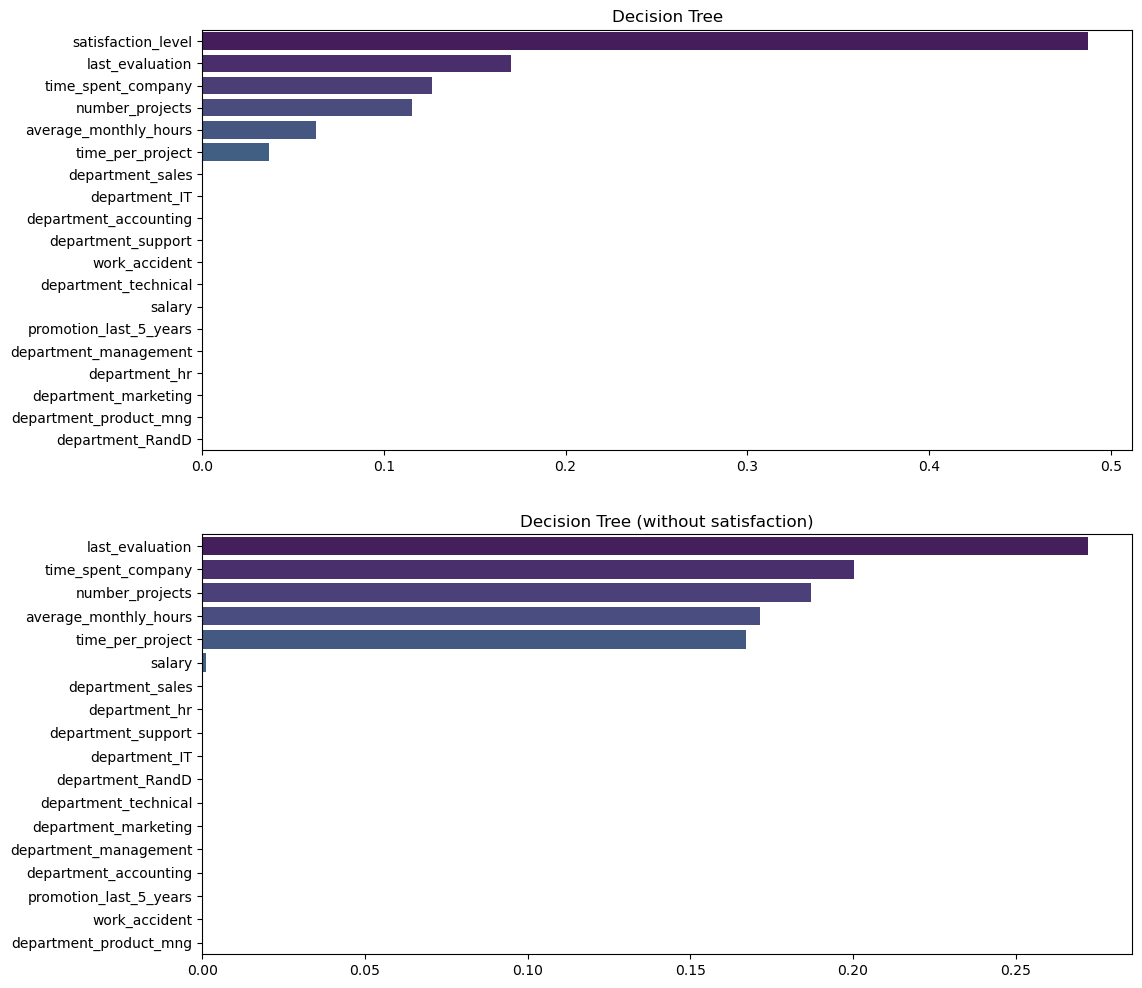

In [7]:
plot_feature_importance(X.columns, dt_grid_search, X_train_nosat.columns, dt_grid_search_nosat, 'Decision Tree')

# LightGBM 

We repeat all the above steps for a LightGBM classifier.

In [8]:
lgbt_classifier = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=42, n_jobs=-1, verbose=-1)

scoring = {'f1': 'f1'}

cv_params = {'max_depth': [5, 6, 7, 9], 'num_leaves': [20, 25, 35, 50], 'learning_rate': [0.175,0.2, 0.22], 'n_estimators': [50, 100]}

lgbt_grid_search = GridSearchCV(estimator=lgbt_classifier, param_grid=cv_params, cv=5, scoring=scoring, refit='f1', return_train_score=True);

lgbt_grid_search.fit(X_train, y_train);

best_params = lgbt_grid_search.best_params_

y_pred_lgbt = lgbt_grid_search.predict(X_test)

results = pd.concat([results, get_model_scores('lgbt', y_pred_lgbt, y_test)])

print(results.iloc[-1, :])

model            lgbt
accuracy      0.98416
precision    0.973684
recall       0.929648
f1           0.951157
Name: 0, dtype: object


We also train the LightGBM model without the satisfaction level.

In [9]:

lgbt_grid_search_nosat = GridSearchCV(estimator=lgbt_classifier, param_grid=cv_params, cv=5, scoring=scoring, refit='f1', return_train_score=True);

lgbt_grid_search_nosat.fit(X_train_nosat, y_train_nosat);

best_params = lgbt_grid_search_nosat.best_params_

y_pred_lgbt_nosat = lgbt_grid_search_nosat.predict(X_test_nosat)

results = pd.concat([results, get_model_scores('lgbt_nosat', y_pred_lgbt_nosat, y_test)])

print(results.iloc[-1, :])

model        lgbt_nosat
accuracy       0.973739
precision      0.932817
recall         0.907035
f1             0.919745
Name: 0, dtype: object


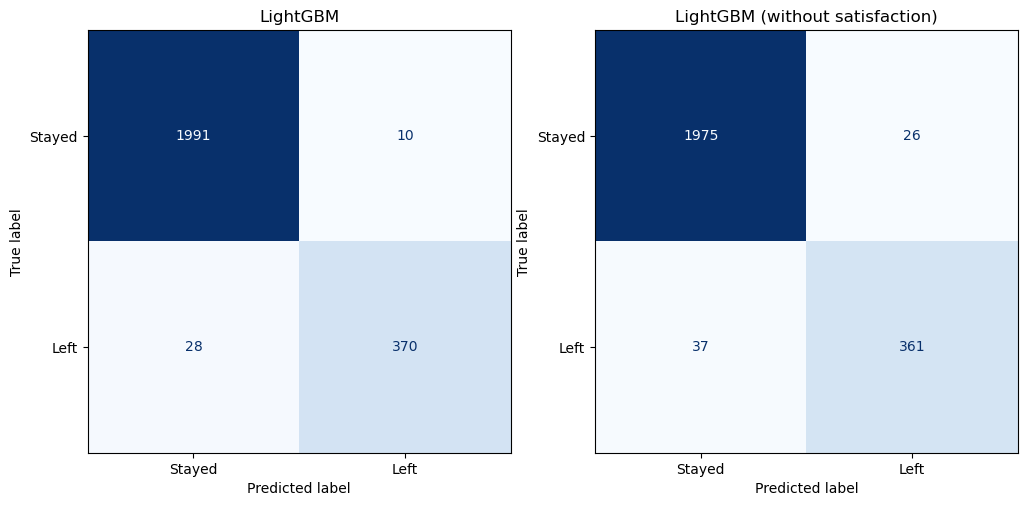

In [10]:
plot_cms(y_pred_lgbt, y_pred_lgbt_nosat, y_test, 'LightGBM')

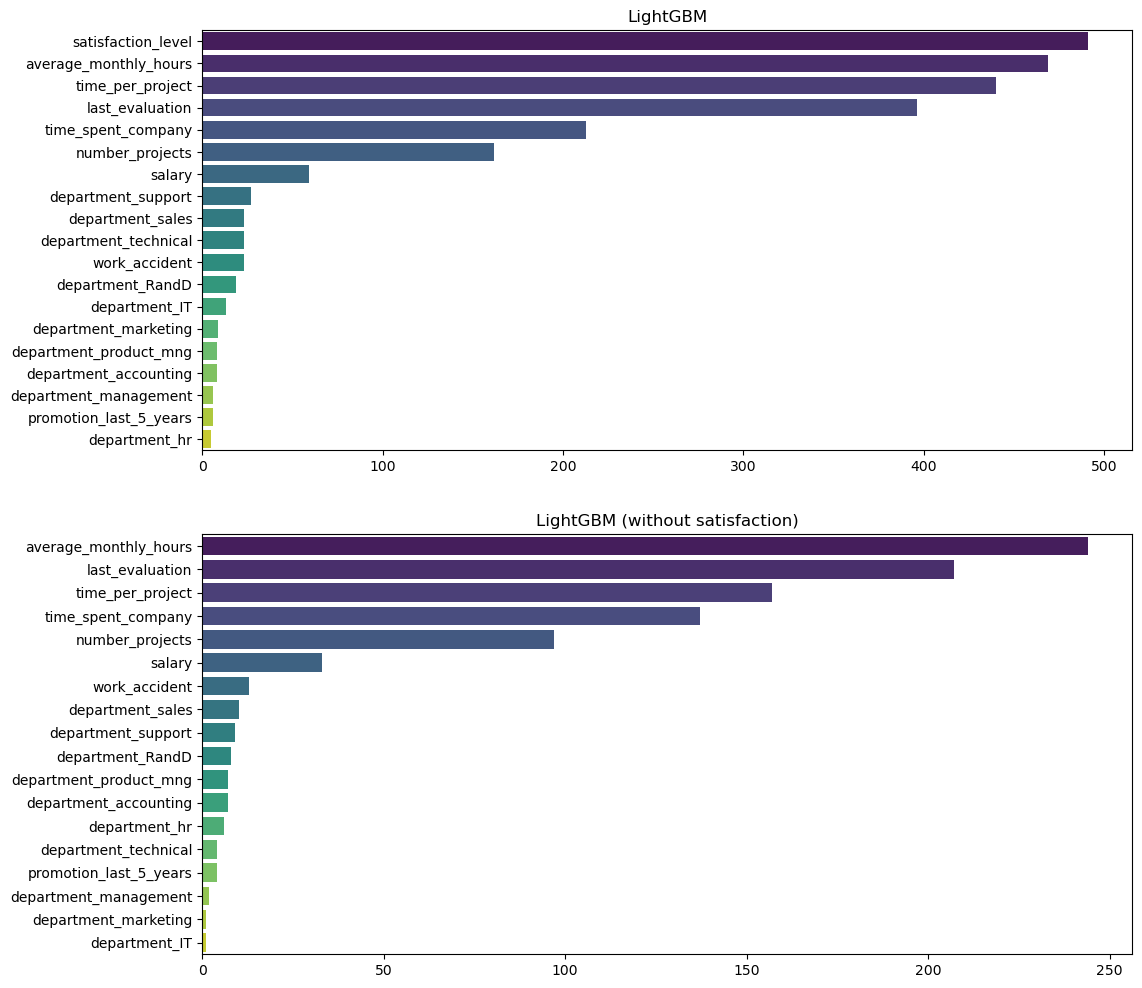

In [11]:
plot_feature_importance(X.columns, lgbt_grid_search, X_train_nosat.columns, lgbt_grid_search_nosat, 'LightGBM')

Overall, the performance difference between the model is quite small. Notably, the boosted classifier puts more weight on a larger number of features compared to the single decision tree model.

# Random Forest

Finally, we repeat the same steps for a Random Forest classifier.

In [12]:
rf_classifier = RandomForestClassifier(random_state=0, n_jobs=-1)

cv_params_rf = {'n_estimators': [50, 100, 150], 'max_depth': [7, 9, 11, 15], 'max_features': [None, 'sqrt', 'log2'],'min_samples_split': [2, 4, 6]}
scoring = {'f1': 'f1'}

rf_grid_search = GridSearchCV(estimator=rf_classifier, param_grid=cv_params_rf, cv=5, scoring=scoring, refit='f1', return_train_score=True)

rf_grid_search.fit(X_train, y_train)

best_params = rf_grid_search.best_params_

y_pred_rf = rf_grid_search.predict(X_test)

results = pd.concat([results, get_model_scores('random_forest', y_pred_rf, y_test)])

print(results.iloc[-1, :])

model        random_forest
accuracy          0.986244
precision         0.989276
recall            0.927136
f1                0.957198
Name: 0, dtype: object


In [13]:
rf_grid_search_nosat = GridSearchCV(estimator=rf_classifier, param_grid=cv_params_rf, cv=5, scoring=scoring, refit='f1', return_train_score=True)

rf_grid_search_nosat.fit(X_train_nosat, y_train_nosat)

best_params = rf_grid_search_nosat.best_params_

y_pred_rf_nosat = rf_grid_search_nosat.predict(X_test_nosat)

results = pd.concat([results, get_model_scores('random_forest_nosat', y_pred_rf_nosat, y_test)])

print(results.iloc[-1, :])

model        random_forest_nosat
accuracy                 0.97624
precision               0.933842
recall                  0.922111
f1                      0.927939
Name: 0, dtype: object


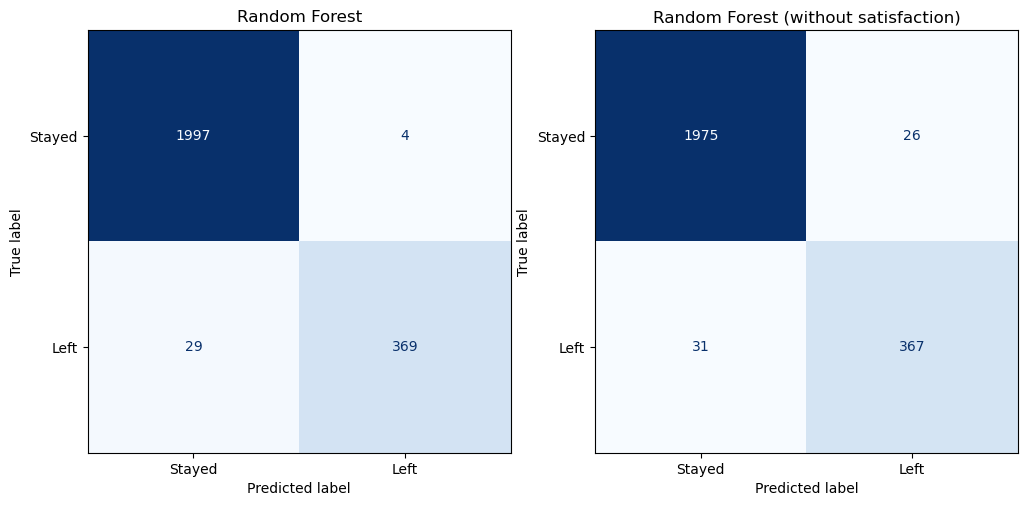

In [14]:
plot_cms(y_pred_rf, y_pred_rf_nosat, y_test, 'Random Forest')

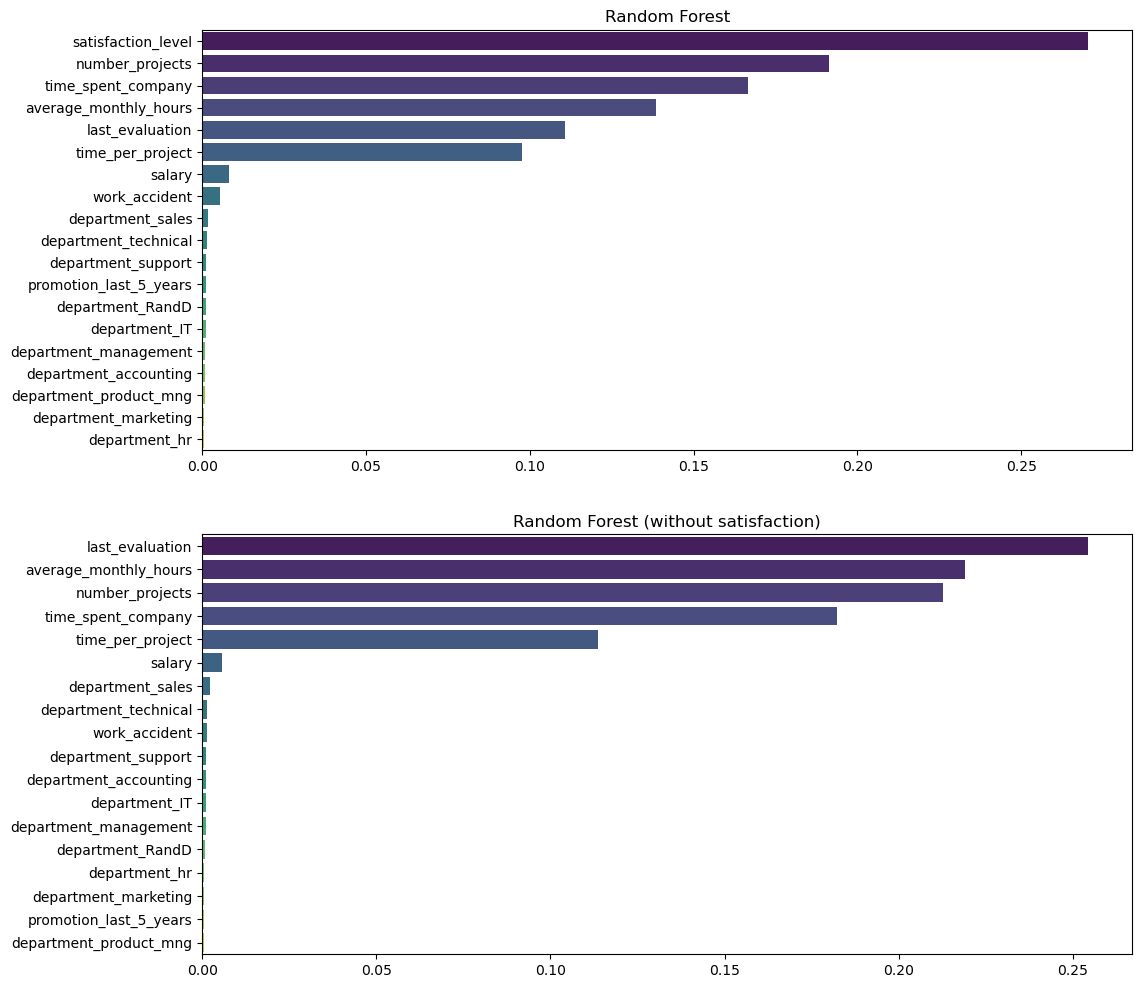

In [15]:
plot_feature_importance(X.columns, rf_grid_search, X_train_nosat.columns, rf_grid_search_nosat, 'Random Forest')

# Conclusion

Overall, the random forest classifier performs best across all metric, in both cases (with and without satisfaction level). However, all classifiers perform quite well, which makes the decision tree an interesting choice, owed to its simplicity and interpretability.

The feature importance confirm the findings of the exploratory data analysis. The employees are overworked, in particular mid to senior level employees, and the company should consider reducing the number of projects and working hours in order to increase employee satisfaction and reduce churn. This is particularly important, as leaving employees tend to have above average evaluations.

In [16]:
results

model  accuracy  precision    recall        f1
0             dec_tree  0.983326   0.973545  0.924623  0.948454
0       dec_tree_nosat  0.974573   0.924433  0.922111  0.923270
0                 lgbt  0.984160   0.973684  0.929648  0.951157
0           lgbt_nosat  0.973739   0.932817  0.907035  0.919745
0        random_forest  0.986244   0.989276  0.927136  0.957198
0  random_forest_nosat  0.976240   0.933842  0.922111  0.927939